In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tomo_encoders.reconstruction.recon import recon_all, fbp_filter, rec_all
from tomo_encoders import DataFile
import dxchange
from tomo_encoders import viewer
import cupy as cp
from tomo_encoders.misc.voxel_processing import modified_autocontrast
from tomo_encoders.misc.viewer import add_scalebar

spefile module not found
netCDF4 module not found
EdfFile module not found
astropy module not found
olefile module not found


In [2]:
fpath = '/data02/MyArchive/tomo_datasets/Sigray_SSD/Tekawade_SSD_050.h5'
# 3201, 2426, 3232
center = 1615.5
pixel_size = 0.6722679580997339
b_K = 16
b = 16
projs, flat, dark, theta = dxchange.read_aps_32id(fpath)
flat = np.median(flat, axis = 0).astype(np.float32)
dark = np.median(dark, axis = 0).astype(np.float32)
projs = projs.astype(np.float32)

In [3]:
ntheta, nz, n = projs.shape
projs = projs[:, :-int(nz%128), :-int(n%128)].copy()
flat = flat[:-int(nz%128), :-int(n%128)].copy()
dark = dark[:-int(nz%128), :-int(n%128)].copy()

In [4]:
from tomo_encoders.reconstruction.recon import recon_binning

In [5]:
cp.fft.config.clear_plan_cache()
vol = recon_binning(projs, theta, center, b_K, b, dark_flat = (dark, flat))

In [6]:
vol.shape

(144, 200, 200)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

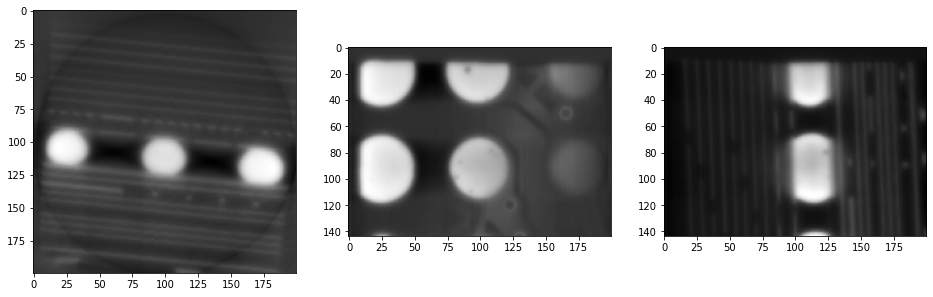

In [7]:
fig, ax = plt.subplots(1,3, figsize = (16,8))
viewer.view_midplanes(vol = vol.get(), ax = ax)

In [8]:
from tomo_encoders.tasks.surface_determination import coarse_segmentation

In [9]:
cp.fft.config.clear_plan_cache()

In [10]:
Vb, min_max = coarse_segmentation(projs, theta, center, b_K, b, 0.5)

	TODO: modified_autocontrast invokes GPU-CPU transfer. need to implement it on GPU
	TIME reconstructing with binning - 2.72 secs


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

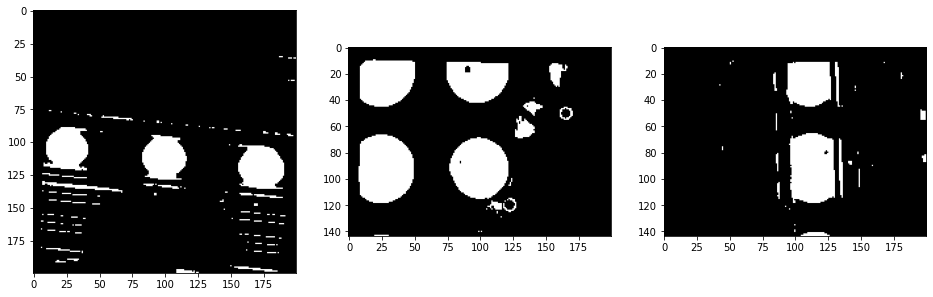

In [11]:
fig, ax = plt.subplots(1,3, figsize = (16,8))
viewer.view_midplanes(vol = Vb.get(), ax = ax)

In [12]:
from cupyx.scipy.ndimage import binary_opening

In [13]:
Vb = binary_opening(Vb, structure = cp.ones((9,9,9), dtype = cp.uint8))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

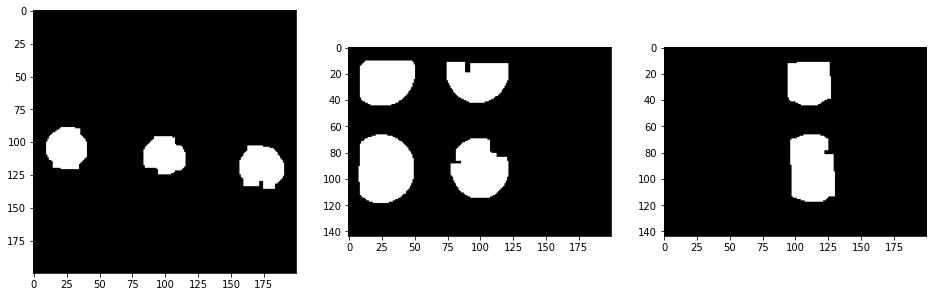

In [14]:
fig, ax = plt.subplots(1,3, figsize = (16,8))
viewer.view_midplanes(vol = Vb.get(), ax = ax)

In [15]:
from tomo_encoders.structures.voids import Voids

In [16]:
voids_b = Voids().guess_voids(Vb, b)    

	STAT: voids found - 6


In [17]:
approx_size = 50.0 # micrometers
dia_list = np.cbrt(voids_b["sizes"])*b*pixel_size

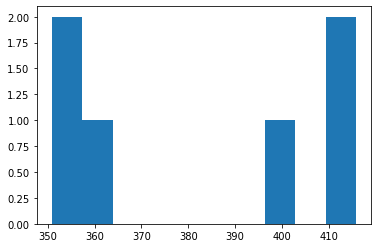

In [18]:
h = plt.hist(dia_list[dia_list > approx_size])

In [19]:
voids_b.select_by_size(approx_size, pixel_size_um = pixel_size)

	STAT: size thres: 4.65 pixel length for 50.00 um threshold


In [20]:
surf = voids_b.export_void_mesh_with_texture("sizes")

	TIME: compute void mesh 0.39 secs


In [21]:
surf.write_ply('/home/atekawade/Dropbox/Arg/transfers/runtime_plots/SSD_vis.ply')

In [22]:
len(voids_b)

6

In [24]:
np.cbrt(voids_b["sizes"])*pixel_size*b

array([352.09308367, 362.17168389, 350.88430921, 399.61802312,
       415.83071316, 412.04428161])

##### 